## Assignment 7

In this assignment, the HTRU2 dataset is used that can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HTRU2).

In this workbook, feature importance techniques are implemented.

In [134]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
import os 

os.chdir('C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt7_FeatureSelection/')

In [35]:
data_file = 'HTRU2/HTRU_2.csv'

data = pd.read_csv(data_file, header=None)


feature_names = ["Mean of the integrated profile",
	"Standard deviation of the integrated profile",
	"Excess kurtosis of the integrated profile",
	"Skewness of the integrated profile",
	"Mean of the DM-SNR curve",
	"Standard deviation of the DM-SNR curve",
	"Excess kurtosis of the DM-SNR curve",
	"Skewness of the DM-SNR curve"]

data.columns = feature_names + ["target_class"]

In [12]:
# check for missing data
if data.isnull().any().sum() > 0:
    plt.figure(figsize=(8,6))
    sns.heatmap(data.isnull(), cmap='gnuplot', yticklabels=False, cbar=False)
    plt.title('Missing values on HTRU2')
    plt.show()
else:
    print('There are no missing values in the data')

There are no missing values in the data


In [4]:
# Run on colab
# plt.figure(figsize=(16,14))
# sns.pairplot(data=data, hue='target_class', palette=['darkorange', 'indigo'])
# plt.suptitle('Pairplot of predictor variables of HTRU2 dataset')
# plt.tight_layout()
# plt.show()

In [23]:
# split in train-test set in a stratified manner

X = data.drop(columns = 'target_class')
y = data['target_class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=556, stratify=y)

In [85]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature importance

Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

### Coefficients as feature importance

Linear machine learning algorithms fit a model where the prediction is the weighted sum of the input values.  
All of these algorithms find a set of coefficients to use in the weighted sum in order to make a prediction. These coefficients can be used directly as a crude type of feature importance score.

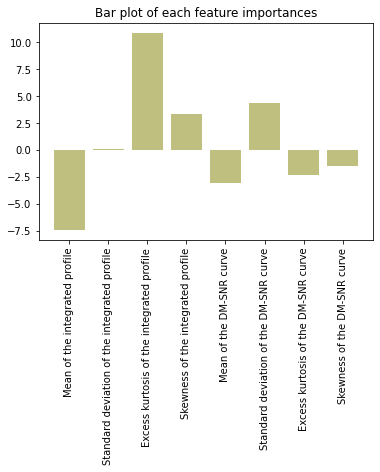

In [212]:
clf = LogisticRegression(random_state=119)

clf.fit(X_train, y_train)
lg_importance = clf.coef_


plt.bar(x=feature_names, height=lg_importance[0], alpha=0.5, color='olive')
plt.xticks(rotation=90)
plt.title('Bar plot of each feature importances')
plt.show()

In [213]:
feat_importance = sorted([(i,abs(x)) for i,x in enumerate(lg_importance[0])], key=lambda x:x[1], reverse=True)
select4 = [x[0] for x in feat_importance[:4]]
select6 = [x[0] for x in feat_importance[:6]]

feature_importance = '\n'.join([(f'{feature_names[x[0]]: <45} : {x[1]:.4f}') for x in feat_importance])
print('Feature importance in decreasing order:')
print(feature_importance)

Feature importance in decreasing order:
Excess kurtosis of the integrated profile     : 10.8979
Mean of the integrated profile                : 7.4617
Standard deviation of the DM-SNR curve        : 4.4048
Skewness of the integrated profile            : 3.3544
Mean of the DM-SNR curve                      : 3.0666
Excess kurtosis of the DM-SNR curve           : 2.3104
Skewness of the DM-SNR curve                  : 1.4604
Standard deviation of the integrated profile  : 0.1157


In [122]:
def print_metrics(num_vars, model_name, y_test, predictions):  
    print(f'Using {num_vars} variables, the metrics for the {model_name} model are: \nAccuracy {accuracy_score(y_test, predictions)*100:.2f}%'
            f'\nPrecision {precision_score(y_test, predictions)*100:.2f}% '
            f'\nRecall {recall_score(y_test, predictions)*100:.2f}% '
            f'\nF1 {f1_score(y_test, predictions)*100:.2f}% ')

predictions = clf.predict(X_test)
print_metrics('all', 'Logistic Regression', y_test, predictions)

Using all variables, the metrics for the Logistic Regression model are: 
Accuracy 63.91%
Precision 18.89% 
Recall 89.28% 
F1 31.18% 


In [124]:
clf = LogisticRegression(random_state=119)
clf.fit(X_train[:, select4], y_train)
predictions = clf.predict(X_test[:, select4])
print_metrics(4, 'Logistic Regression', y_test, predictions)

Using 4 variables, the metrics for the Logistic Regression model are: 
Accuracy 19.76%
Precision 9.60% 
Recall 92.24% 
F1 17.39% 


In [125]:
clf = LogisticRegression(random_state=119)
clf.fit(X_train[:, select6], y_train)
predictions = clf.predict(X_test[:, select6])
print_metrics(6, 'Logistic Regression', y_test, predictions)

Using 6 variables, the metrics for the Logistic Regression model are: 
Accuracy 91.23%
Precision 100.00% 
Recall 4.25% 
F1 8.16% 


### Tree-based algorithms Feature importance

In XGBoost importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

*Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for.*

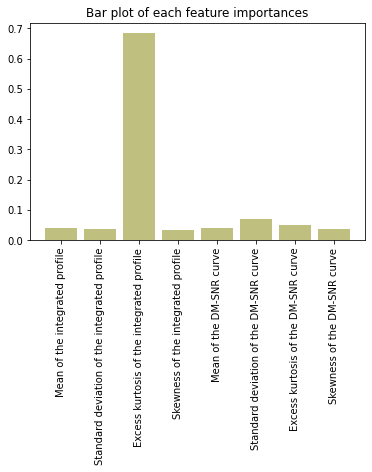

In [126]:
clf = XGBClassifier(random_state=546)

clf.fit(X_train, y_train)
xgb_importance = clf.feature_importances_


plt.bar(x=feature_names, height=xgb_importance, alpha=0.5, color='olive')
plt.xticks(rotation=90)
plt.title('Bar plot of each feature importances')
plt.show()

In [217]:
feat_importance = sorted([(i,x) for i,x in enumerate(xgb_importance)], key=lambda x:x[1], reverse=True)
select4 = [x[0] for x in feat_importance[:4]]
select6 = [x[0] for x in feat_importance[:6]]

feature_importance = '\n'.join([(f'{feature_names[x[0]]: <45} : {x[1]:.4f}') for x in feat_importance])
print('Feature importance in decreasing order:')
print(feature_importance)

Feature importance in decreasing order:
Excess kurtosis of the integrated profile     : 0.6841
Standard deviation of the DM-SNR curve        : 0.0711
Excess kurtosis of the DM-SNR curve           : 0.0518
Mean of the DM-SNR curve                      : 0.0416
Mean of the integrated profile                : 0.0411
Standard deviation of the integrated profile  : 0.0374
Skewness of the DM-SNR curve                  : 0.0374
Skewness of the integrated profile            : 0.0355


In [129]:
predictions = clf.predict(X_test)
print_metrics('all', 'XGBoost Classifier', y_test, predictions)

Using all variables, the metrics for the XGBoost Classifier model are: 
Accuracy 63.91%
Precision 18.89% 
Recall 89.28% 
F1 31.18% 


In [130]:
clf = XGBClassifier(random_state=546)
clf.fit(X_train[:, select4], y_train)
predictions = clf.predict(X_test[:, select4])
print_metrics(4, 'Logistic Regression', y_test, predictions)

Using 4 variables, the metrics for the Logistic Regression model are: 
Accuracy 58.08%
Precision 17.78% 
Recall 98.71% 
F1 30.14% 


In [131]:
clf = XGBClassifier(random_state=546)
clf.fit(X_train[:, select6], y_train)
predictions = clf.predict(X_test[:, select6])
print_metrics(6, 'Logistic Regression', y_test, predictions)

Using 6 variables, the metrics for the Logistic Regression model are: 
Accuracy 66.02%
Precision 20.94% 
Recall 97.60% 
F1 34.48% 


### Permutation Feature Importance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.  
The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model's prediction error after permuting the feature. A feature is "important" if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is "unimportant" if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 

More detailed [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

Permutation importance is calculated using [eli5](https://eli5.readthedocs.io/en/latest/) library. The output is in HTML format, therefore it can only be used in an ipython notebook.

In [173]:
clf = RandomForestClassifier(n_estimators=100, random_state=119)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print_metrics('all', 'Random Forest', y_test, predictions)

Using all variables, the metrics for the Random Forest model are: 
Accuracy 68.90%
Precision 18.17% 
Recall 68.39% 
F1 28.72% 


In [181]:
permuter = PermutationImportance(clf, cv='prefit', scoring='recall', n_iter=5, random_state=42)
permuter.fit(X_test, y_test)

eli5.show_weights(permuter, feature_names=[f'{i+1}_{name}' for i, name in enumerate(feature_names)])

Weight,Feature
0.3948 ± 0.0473,3_Excess kurtosis of the integrated profile
0.2758 ± 0.0451,4_Skewness of the integrated profile
0.0015 ± 0.0028,7_Excess kurtosis of the DM-SNR curve
0 ± 0.0000,6_Standard deviation of the DM-SNR curve
0 ± 0.0000,2_Standard deviation of the integrated profile
0 ± 0.0000,1_Mean of the integrated profile
-0.0044 ± 0.0050,5_Mean of the DM-SNR curve
-0.2189 ± 0.0265,8_Skewness of the DM-SNR curve


In [219]:
feat_importance = sorted([(i,x) for i,x in enumerate(np.mean(permuter.results_, axis=0))], key=lambda x:x[1], reverse=True)
select4 = [x[0] for x in feat_importance[:4]]
select6 = [x[0] for x in feat_importance[:6]]

In [220]:
clf = RandomForestClassifier(n_estimators=100, random_state=119)
clf.fit(X_train[:, select4], y_train)
predictions = clf.predict(X_test[:, select4])
print_metrics(4, 'Random Forest Classifier', y_test, predictions)

Using 4 variables, the metrics for the Random Forest Classifier model are: 
Accuracy 74.91%
Precision 26.32% 
Recall 96.67% 
F1 41.38% 


In [221]:
clf = RandomForestClassifier(n_estimators=100, random_state=119)
clf.fit(X_train[:, select6], y_train)
predictions = clf.predict(X_test[:, select6])
print_metrics(6, 'Random Forest Classifier', y_test, predictions)

Using 6 variables, the metrics for the Random Forest Classifier model are: 
Accuracy 65.30%
Precision 19.42% 
Recall 88.54% 
F1 31.85% 
